In [180]:
import pandas as pd
import json
import glob
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.dates as md

from tensorflow import keras

from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import StandardScaler

from itertools import combinations, product

from src.colnames import topic_col, emotion_col, style_col, exclude_col
from utils import _pca_transform

### Structure
Content and narratives
- Topic modeling of EU Commission tweets
- Which topics generate most engagement (likes, comments, retweets, quotes)? 
- Which topics generate most positive comments? 
- Which narratives resonate the most?

Styles and emotional content

Predictive modeling
- Bag of words models
- Topic models
- Transformer-based models
- Style-based
- Sentiment-based

In [214]:
fs = glob.glob('data/derivatives/*')
dfs = []
for f in fs:
    d = pd.read_json(f, orient='records', lines=True)
    d['entity'] = '_'.join(f.split('/')[-1].split('.')[0].split('_')[:-1])
    dfs.append(d)

In [215]:
df = pd.concat(dfs, ignore_index=True)

## Style

#### Compare style variables across accounts

In [216]:
style_targets = [c for c in df.columns if any(['rauh' in c, 
                                               'benoit' in c, 
                                               'alpha_ratio' in c])]
sentiment_targets = [c for c in df.columns if 'sentiment' in c]

In [217]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

ests = []
for t in style_targets + sentiment_targets:
    scaler = StandardScaler()
    new_t_name = t.replace('-','_')
    data = df.rename({t: new_t_name}, axis=1).fillna(0)
    data[new_t_name] = scaler.fit_transform(data[[new_t_name]])
    formula = f"{new_t_name} ~ C(entity, Treatment(reference='EU_Commission'))"
    
    # Specify model
    mod = smf.rlm(formula, data=data, M=sm.robust.norms.HuberT())
    
    # Freq workflow
    res = mod.fit()
    # print(f'\n{t}\n')
    # print(res.summary())
    
    # Save estimates
    est_df = pd.DataFrame(res.params, columns=['param'])
    est_df['predictor'] = est_df.index.str.replace(r"C\(entity, Treatment\(reference='EU_Commission'\)\)\[T\.", "", regex=True)
    est_df['predictor'] = est_df['predictor'].str.replace(r"\]", "", regex=True)
    est_df['target'] = t
    est_df['p_val'] = res.pvalues.values
    est_df = est_df.reset_index(drop=True)
    est_df = est_df[est_df['predictor']!='Intercept']
    ests.append(est_df)
    
# Make joint dataset
ests = pd.concat(ests)
conditions = [
    (ests["p_val"].lt(0.001)),
    (ests["p_val"].ge(0.001) & ests["p_val"].lt(0.01)),
    (ests["p_val"].ge(0.01) & ests["p_val"].lt(0.05)),
    (ests["p_val"].ge(0.05)),
]

choices = ["", "", "", 'ns']
ests["p_val"] = np.select(conditions, choices)
ests['param_str'] =  '$' + ests['param'].round(2).astype(str) + '^{' + ests['p_val'] + '}$'

In [218]:
param_categories = ['sentence complexity', 'sentence complexity', 'action', 
                    'readability', 'sentence complexity', 
                    'sentence complexity', 'word complexity', 
                    'word complexity', 'sentiment',
                    'sentiment', 'sentiment', 'word complexity', 'readability', 'action']
sort_entities = ['10DowningStreet', 'scotgov', 
                 'UN', 'Europarl_EN', 'EUCouncil', 
                 'ecb', 'IMFNews', 'OECD']

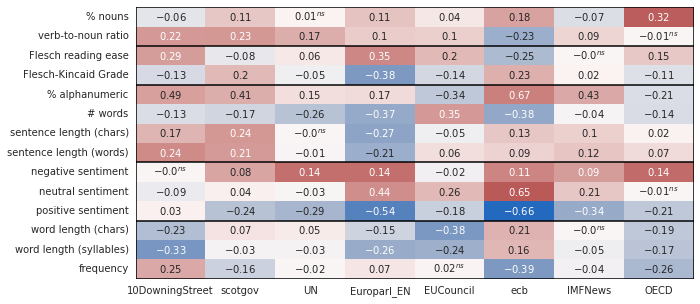

In [222]:
fig, ax = plt.subplots(figsize=(10,5))

wide_params = ests.pivot("target", "predictor", "param")
wide_params = wide_params[sort_entities]
wide_params['category'] = param_categories
wide_params = wide_params.reset_index().sort_values(by='category').set_index('target')
wide_params.index = ['% nouns', 'verb-to-noun ratio',
                     'Flesch reading ease', 'Flesch-Kincaid Grade',
                     '% alphanumeric', '# words',
                     'sentence length (chars)', 'sentence length (words)', 
                     'negative sentiment', 'neutral sentiment', 'positive sentiment',
                     'word length (chars)', 'word length (syllables)',
                     'frequency']
wide_params.index = pd.CategoricalIndex(wide_params.index)

annot = ests.pivot("target", "predictor", "param_str")
annot = annot[sort_entities]
annot.index = wide_params.index
annot['category'] = param_categories
annot = annot.reset_index().sort_values(by='category').set_index('index')
annot.index = pd.CategoricalIndex(annot.index)

data = wide_params.drop('category', axis=1)
sns.heatmap((data/np.vstack([data.std(axis=1).values]*8).T).values,
             cbar=False, cmap='vlag', 
             annot=annot.drop('category', axis=1),
             fmt = '', center=0)
plt.xticks(ticks=np.array(range(len(data.columns)))+.5, 
           labels=data.columns)
plt.yticks(ticks=np.array(range(len(data.index)))+.5,
           labels=data.index, rotation=0)
for i in [0,2,4,8,11,14]:
    plt.axhline(i, color='black')
plt.axvline(0, color='black')
plt.axvline(8, color='black')
plt.xlabel('')
plt.show()

#### Overall style similarity

In [320]:
# TODO: represent overall similarity

Prediction-based similarity

In [267]:
edict = dict(zip(list(wide_params.columns[:-1]) + ['EU_Commission'], 
                 range(len(wide_params.columns[:-1]) + 1)))

0.239


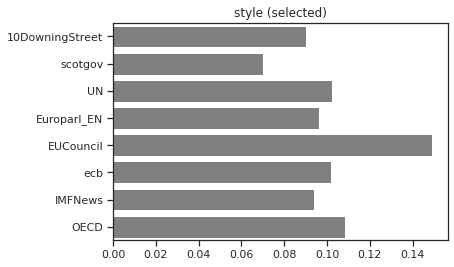

0.171


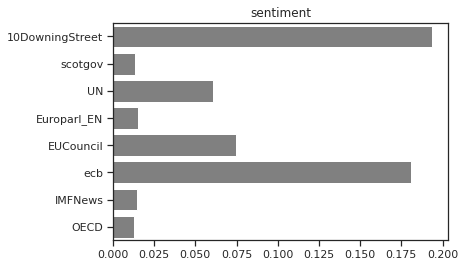

In [284]:
features = [style_targets, sentiment_targets]
for feature, name in zip(features,
                         ['style (selected)', 'sentiment']):
    scaler = StandardScaler()
    
    # Make datasets
    trains = []; vals = [];
    for e in list(wide_params.columns[:-1]) + ['EU_Commission']:
        trains.append(df[df['entity']==e].sample(2000, replace=True))
        vals.append(df[df['entity']==e].sample(1000, replace=True))
    trains = pd.concat(trains).sample(frac=1)
    train_X = scaler.fit_transform(trains[feature].fillna(0).values)
    train_y = trains['entity'].map(edict)
    vals = pd.concat(vals).sample(frac=1)
    val_X = scaler.fit_transform(vals[feature].fillna(0).values)
    val_y = vals['entity'].map(edict)
    
    # Define model
    inputs = keras.Input(shape=(len(feature)))
    x = keras.layers.Dense(units=len(feature))(inputs)
    outputs = keras.layers.Dense(9, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer='rmsprop', 
                  loss='sparse_categorical_crossentropy',
                  metrics='accuracy')
    
    # Fit and evaluate
    model.fit(train_X, train_y, epochs=100, 
              verbose=0,
              validation_split=.2, 
              callbacks=keras.callbacks.EarlyStopping(patience=3))
    
    # Plot
    print(round(model.evaluate(val_X, val_y, verbose=0)[1],3))
    preds = model.predict(val_X)
    cm = pd.DataFrame(confusion_matrix(val_y, np.argmax(preds, axis=1)))
    cm.index = list(edict.keys())
    avg_conf = np.mean(np.vstack([cm.iloc[-1,:] / cm.iloc[-1,:].sum(),
                                  cm.iloc[:,-1] / cm.sum(axis=1)
                                 ]), axis=0)
    sns.barplot(y=cm.index[:-1], x=avg_conf[:-1], color='grey')
    
    plt.title(name)
    plt.show()

Testing in terms of performance of binary classifiers

In [302]:
perfs = []
for i in range(10):
    print(f'Run {i}')
    
    for feature, name in zip(features,
                             ['style (selected)', 'sentiment']):
        for e in wide_params.columns[:-1]:

            scaler = StandardScaler()

            # Make datasets
            trains = []; vals = [];
            for en in [e, 'EU_Commission']:
                trains.append(df[df['entity']==en].sample(1000, replace=True))
                vals.append(df[df['entity']==en].sample(1000, replace=True))
            trains = pd.concat(trains).sample(frac=1)
            train_X = scaler.fit_transform(trains[feature].fillna(0).values)
            train_y = trains['entity'].map({e: 1.0, 'EU_Commission': 0.0})
            vals = pd.concat(vals).sample(frac=1)
            val_X = scaler.fit_transform(vals[feature].fillna(0).values)
            val_y = vals['entity'].map({e: 1.0, 'EU_Commission': 0.0})

            # Define model
            inputs = keras.Input(shape=(len(feature)))
            x = keras.layers.Dense(units=len(feature))(inputs)
            x = keras.layers.Dense(units=len(feature))(x)
            outputs = keras.layers.Dense(1, activation='sigmoid')(x)
            model = keras.Model(inputs, outputs)
            model.compile(optimizer='rmsprop', 
                          loss=keras.losses.BinaryCrossentropy(from_logits=False),
                          metrics='accuracy')

            # Fit and evaluate
            model.fit(train_X, train_y, epochs=100, 
                      verbose=0,
                      validation_split=.2, 
                      callbacks=keras.callbacks.EarlyStopping(patience=3))

            # Plot
            perfs.append((name, e, round(model.evaluate(val_X, val_y, verbose=0)[1],3)))

Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9


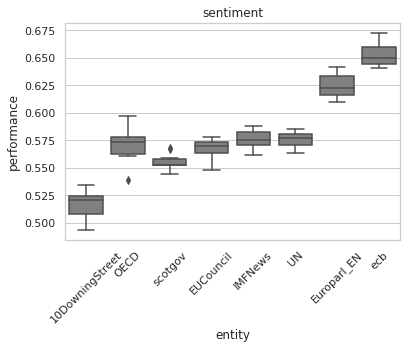

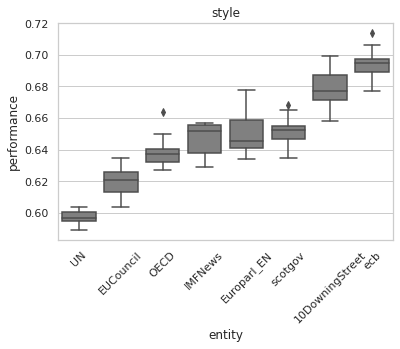

In [339]:
sns.set_style('whitegrid')
perf_df = pd.DataFrame(perfs,columns=['name','entity','performance'])
sns.boxplot(data=perf_df[perf_df['name']=='sentiment'].sort_values(by=['performance']), 
            x='entity', y='performance', color='grey')
plt.xticks(rotation=45)
plt.title('sentiment')
plt.show()

sns.boxplot(data=perf_df[perf_df['name']!='sentiment'].sort_values(by=['performance']), 
            x='entity', y='performance', color='grey')
plt.xticks(rotation=45)
plt.title('style')
plt.show()

### Sentiment

In [340]:
freq_dict = {'D': 'day', 'W': 'week', 'M': 'month'}
figsizes = {'D': (23,5), 'W': (25,5), 'M': (30, 5)}
formats = {'D': '%Y-%m-%d', 'W': '%Y-%m-%d', 'M': '%Y-%m'}
colors = ['indianred', 'grey', sns.color_palette()[0]]


def plot_volume(freq='D', roll_window=7, outcomes=[], save=False, savename='sentiment_over_time',
                entity='EU_Commission', ylim=None):
    data = df[df['entity']==entity]
    fig, ax = plt.subplots(figsize=figsizes[freq])
    grouper = pd.Grouper(key='created_at', axis=0, freq=freq)
    grouped = data.groupby(grouper).mean().reset_index()
    for i,s in enumerate(outcomes):
        grouped[f'{s}_smoothed'] = grouped[s].rolling(roll_window,
                                                      min_periods=1).mean()
        sns.lineplot(data=grouped, 
                     x='created_at', 
                     y=s, 
                     alpha=.2,
                     color=colors[i])
        sns.lineplot(data=grouped, 
                     x='created_at', 
                     y=f'{s}_smoothed', 
                     label=s.replace('_',' ').capitalize(), 
                     color=colors[i])
    plt.ylabel(f'Score')
    plt.xlabel('')
    plt.title(f'{entity}')
    plt.xticks(rotation=60)
    # Make year boundaries
    for d in grouped.created_at.dt.year.unique():
        plt.axvline(x=np.datetime64(f'{d}-01-01'), color='darkgrey', linestyle='--')
        plt.annotate(text=d, xy=(np.datetime64(f'{d}-06-01'),.97), color='black')
    ax.xaxis.set_major_locator(md.MonthLocator((1,7)))
    ax.xaxis.set_major_formatter(md.DateFormatter('%b \'%y'))
    plt.xlim(np.datetime64('2010-05-01'),np.datetime64('2022-09-01'))
    if ylim:
        plt.ylim(ylim)
    if save:
        plt.savefig(f'figs/{savename}.pdf')
    plt.show()

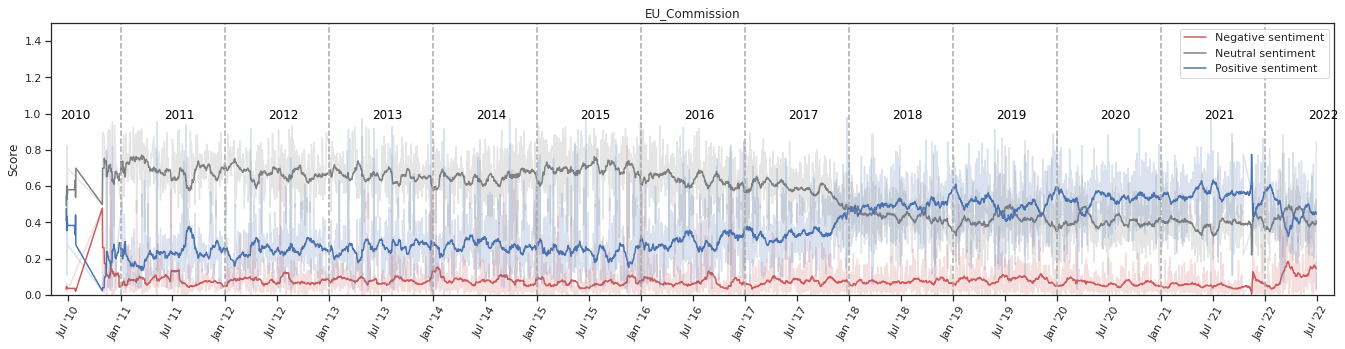

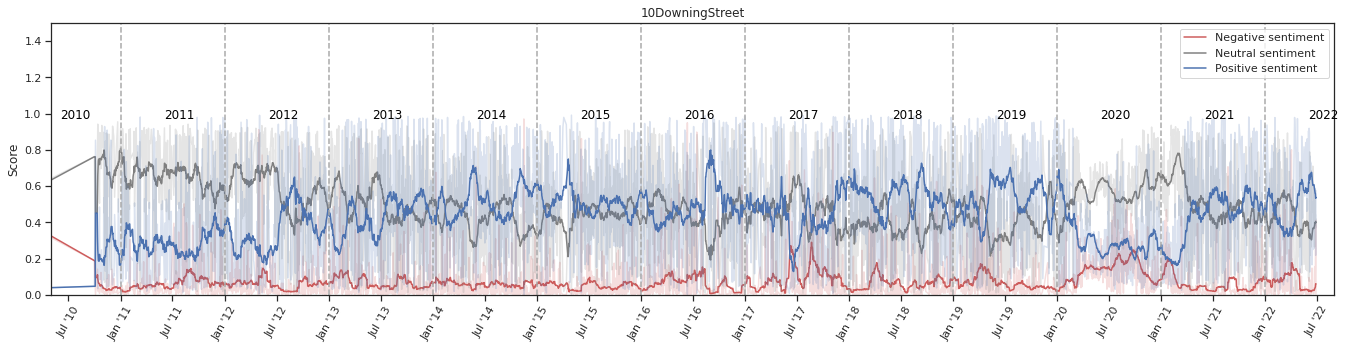

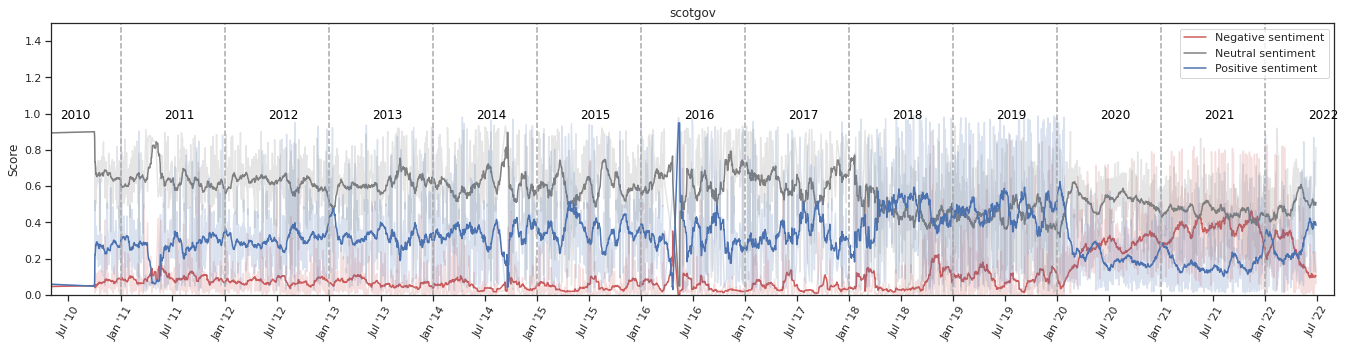

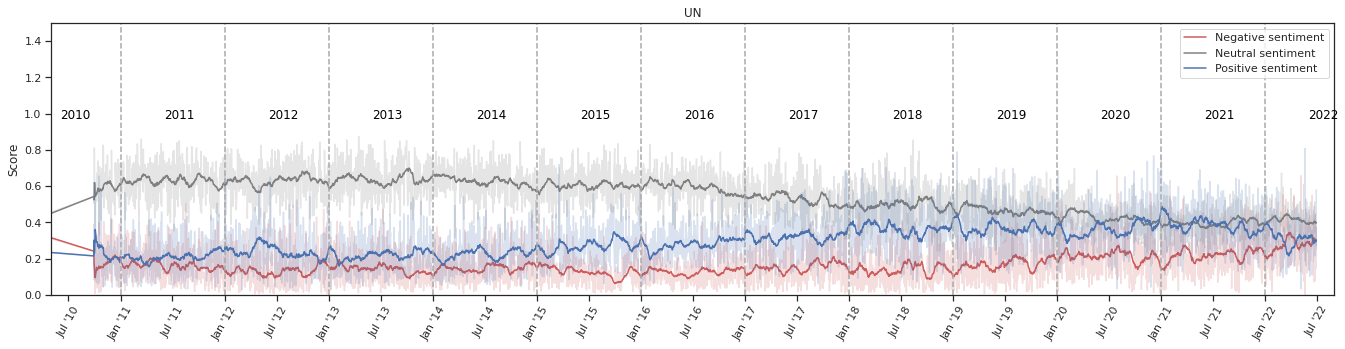

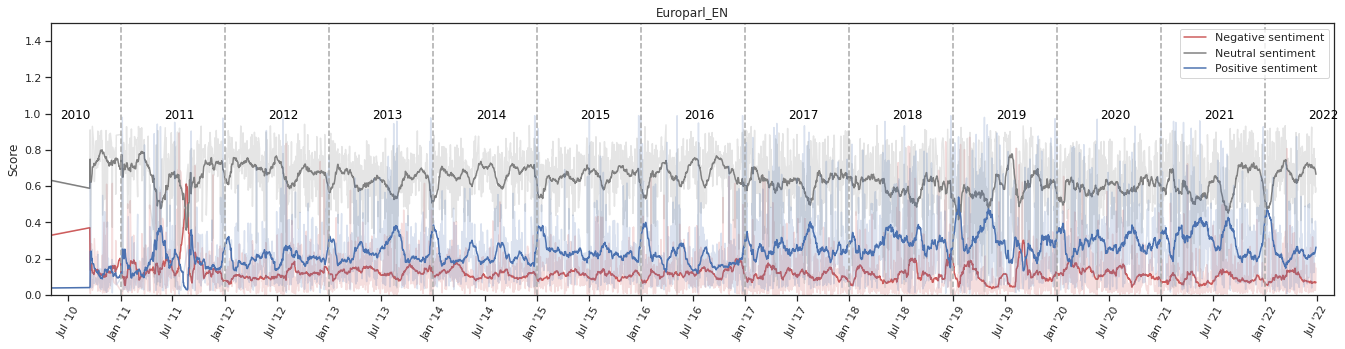

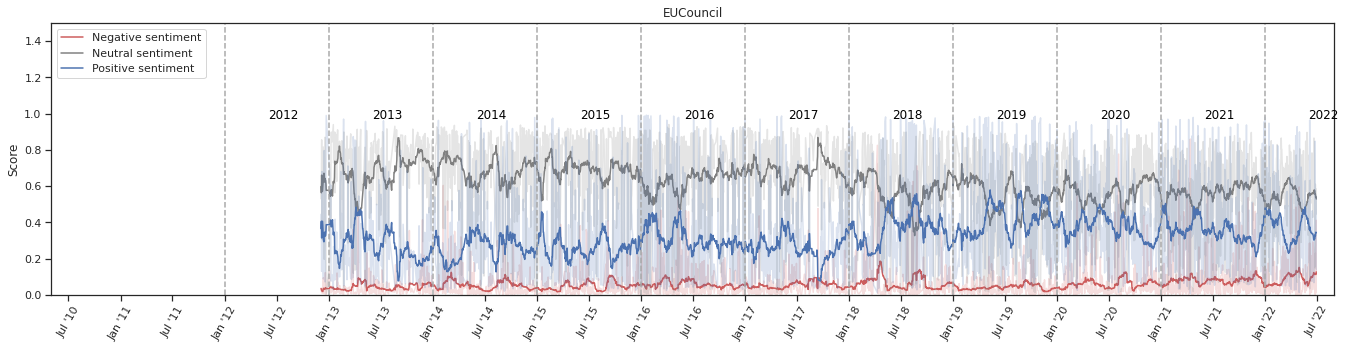

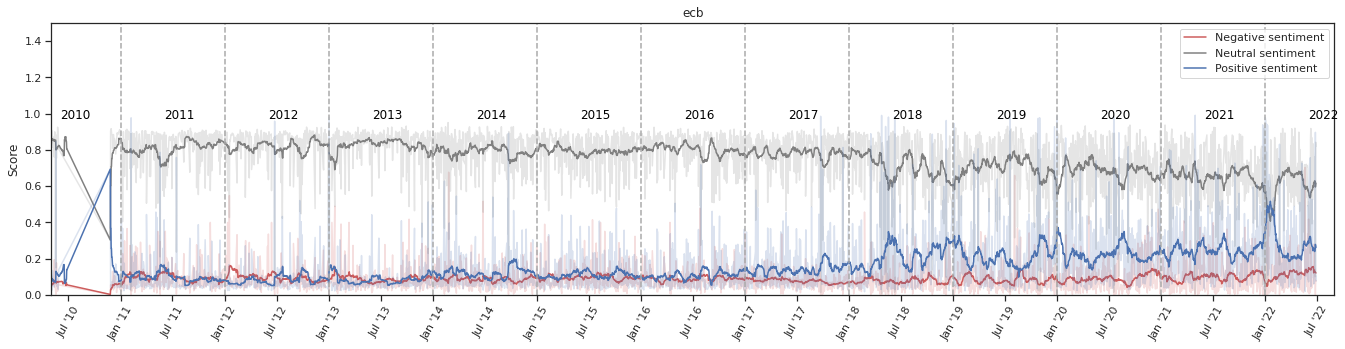

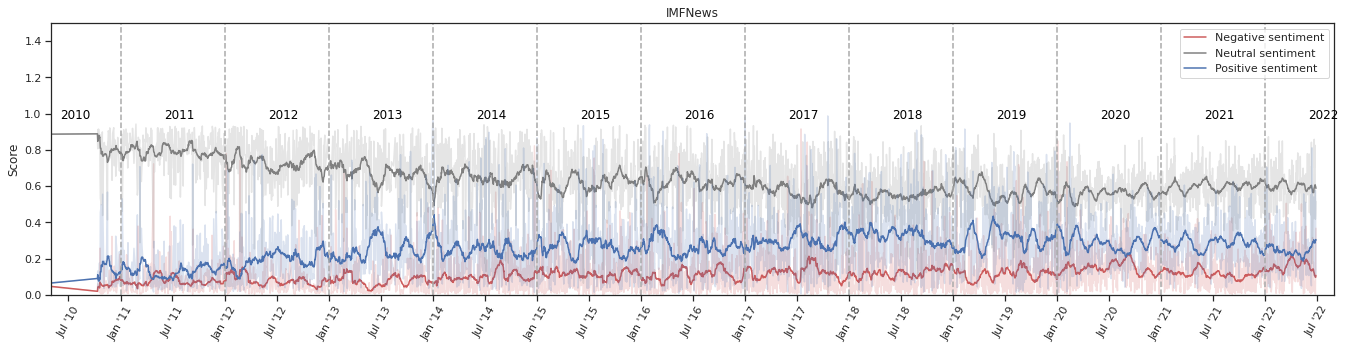

In [341]:
sns.set_style('ticks')
for entity in ['EU_Commission', '10DowningStreet', 'scotgov',
               'UN', 'Europarl_EN', 'EUCouncil', 
               'ecb', 'IMFNews']:
    plot_volume(freq='D',roll_window=30, outcomes=['negative_sentiment', 
                                                   'neutral_sentiment',
                                                   'positive_sentiment'], 
                save=True, savename=f'sentiment_{entity}.png', 
                entity=entity, ylim=(0,1.5))

### Results of predictive models

#### Inspect transformers models

In [342]:
d = json.load(open('logs/transformers/sum_count.json'))

In [343]:
tr_res = pd.DataFrame(d).sort_values(by='test_r2')
tr_res['model'] = tr_res['model'].str.replace('sum_count_', '')

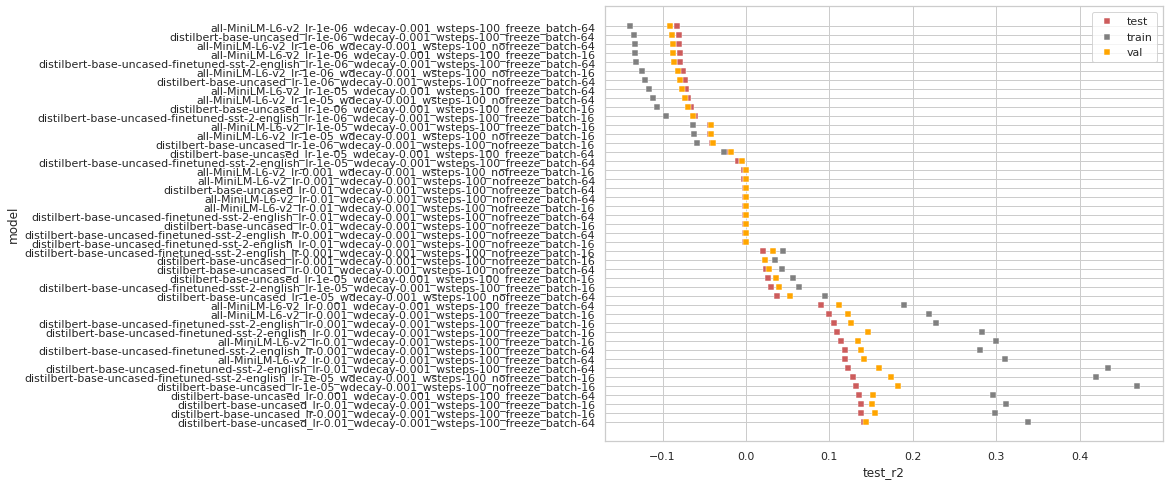

In [344]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(10,8))
sns.scatterplot(data=tr_res, x='test_r2', y='model', label='test', color='indianred', marker='s')
sns.scatterplot(data=tr_res, x='train_r2', y='model', label='train', color='grey', marker='s')
sns.scatterplot(data=tr_res, x='val_r2', y='model', label='val', color='orange', marker='s')
plt.show()

In [ ]:
dfs = []
for metric in ['sum']:
    fs = glob.glob(f'logs/metrics/with_cv/{metric}_count/pred*.pkl')
    for f in fs:
        f_df = pd.read_pickle(f)
        f_df['metric'] = metric
        dfs.append(f_df)
    metrics = pd.concat(dfs, ignore_index=True)
    

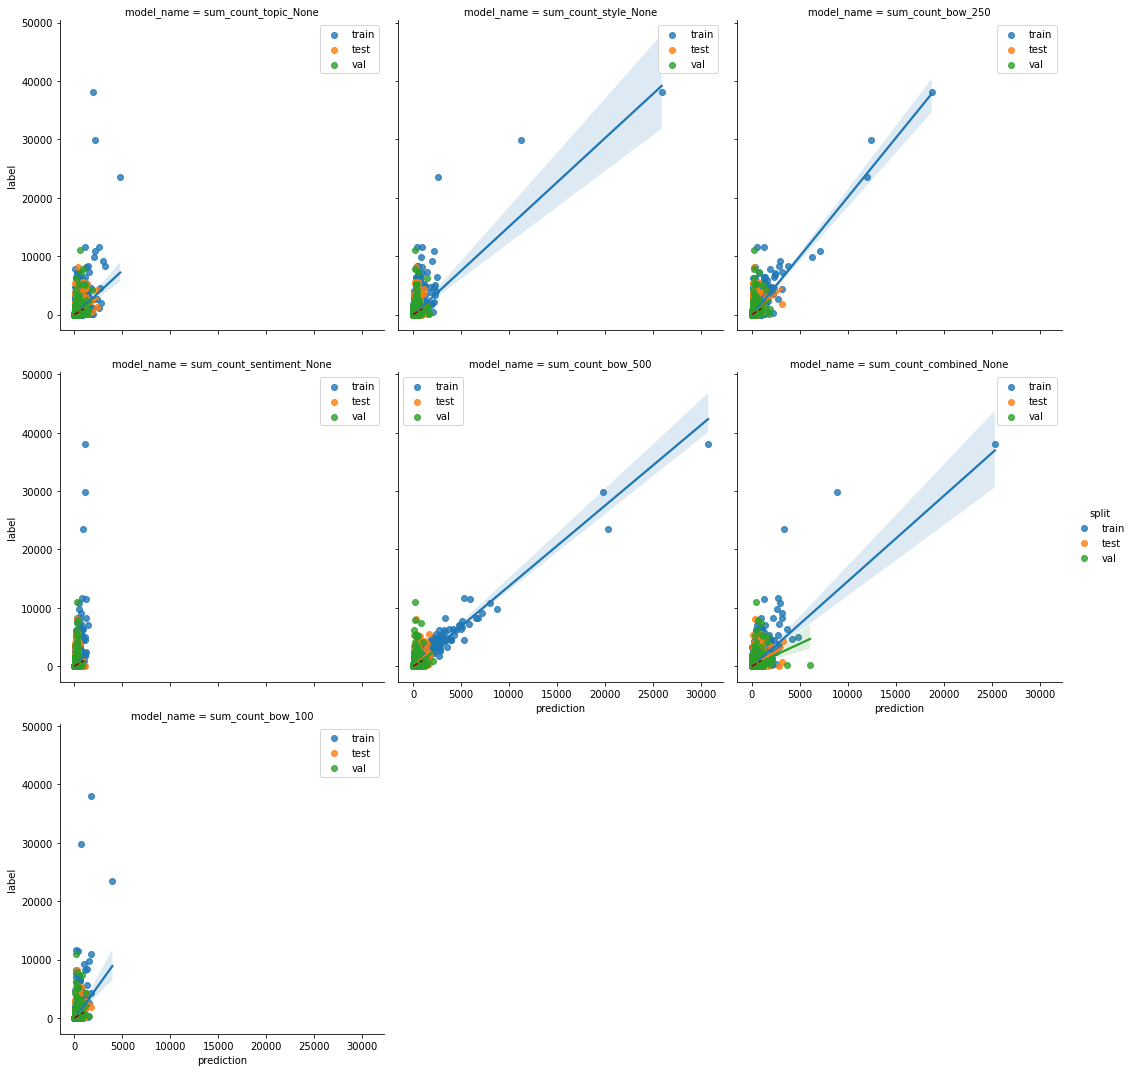

In [146]:
for metric in ['sum']:
    g = sns.lmplot(data=metrics[(metrics['split']=='test') & \
                                (metrics['metric']==metric)], 
                   x='prediction', y='label', 
                   hue='split',
                   col='model_name',
                   col_wrap=3)
    for a in g.axes:
        sns.lineplot(x=[1,500,1000], y=[1,500,1000], ax=a, 
                     color='darkred', linestyle='--')
    plt.show()

In [205]:
spears = metrics.groupby(['metric', 'split',
                 'model_name'])[['label', 'prediction']].apply(lambda x: x.corr('spearman').iloc[0,1]).reset_index()

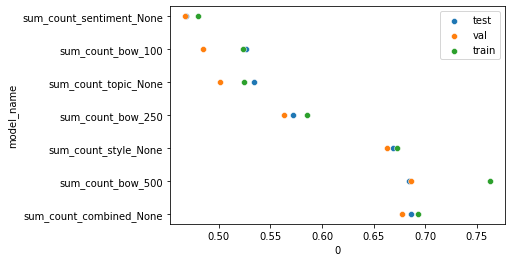

In [206]:
for metric in ['sum']:
    for out_metric in [0]:
        spears = spears.sort_values(by=out_metric, ascending=True)
        for split in ['test',  'val', 'train']:
            sns.scatterplot(data=spears[(spears['split']==split) & \
                                        (spears['metric']==metric)],
                            y='model_name', x=0, label=split)
        plt.show()

### Predictive models

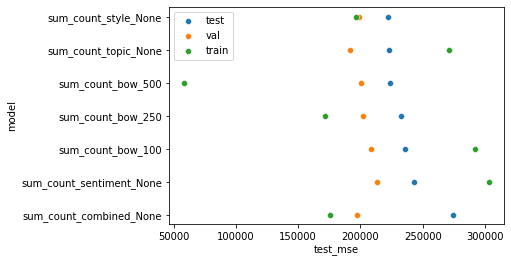

In [213]:
for metric in ['sum']:
    data = pd.DataFrame(json.load(open(f'logs/metrics/with_cv/{metric}_count.json')))
    for out_metric in ['mse']:
        data = data.sort_values(by=f'test_{out_metric}', ascending=True)
        for split in ['test',  'val', 'train']:
            sns.scatterplot(data=data, y='model', x=f'{split}_{out_metric}', label=split)
        plt.show()

***** sum *****


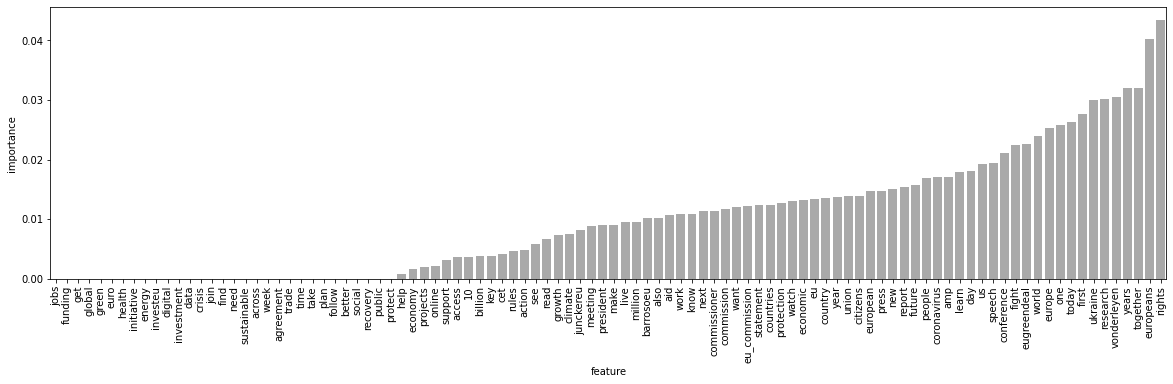

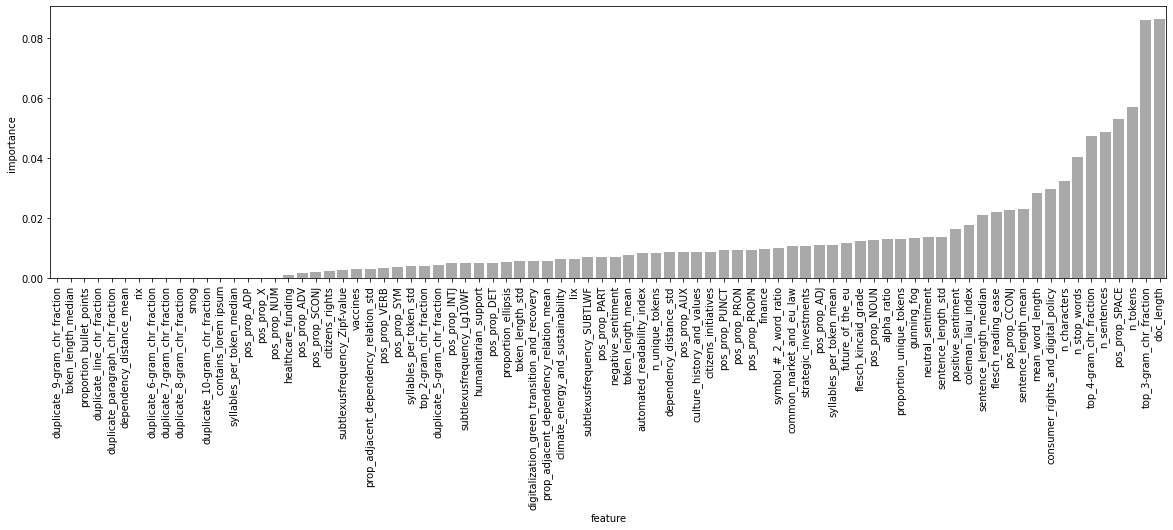

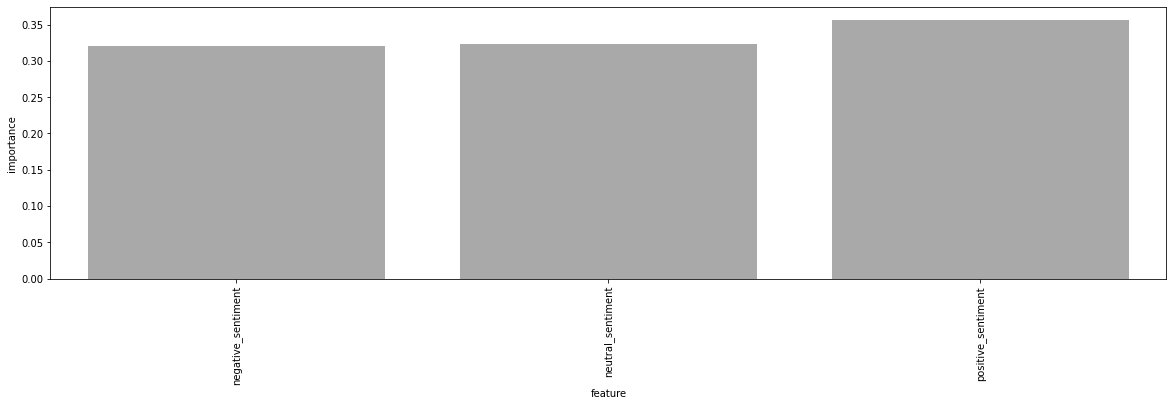

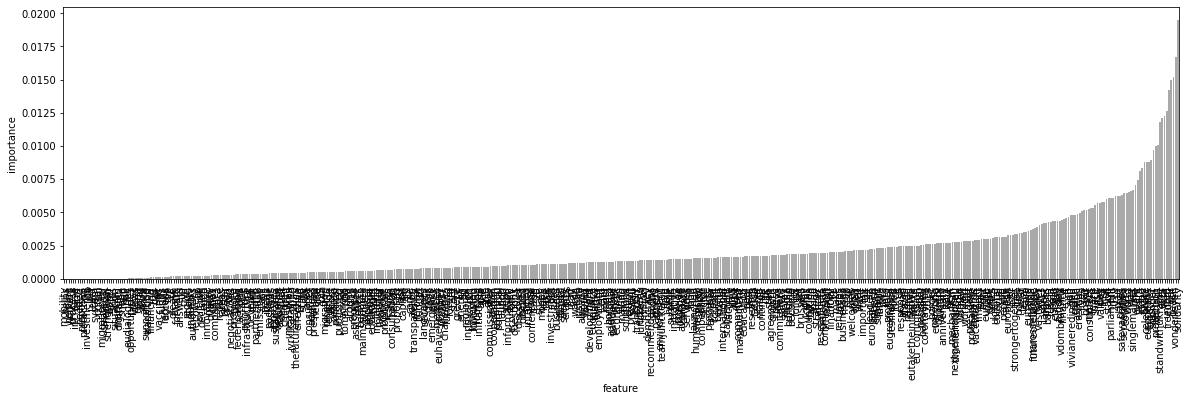

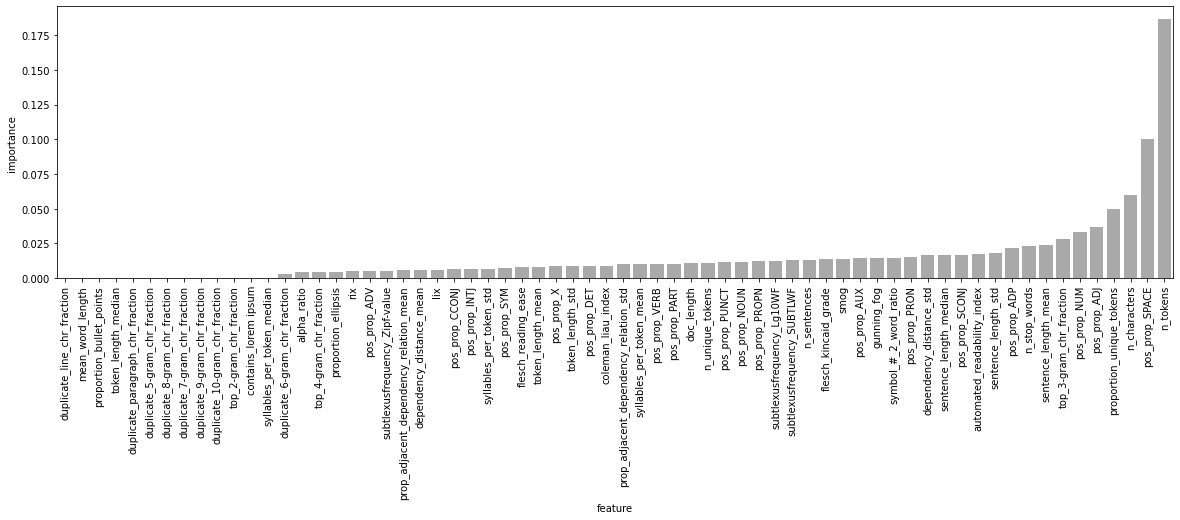

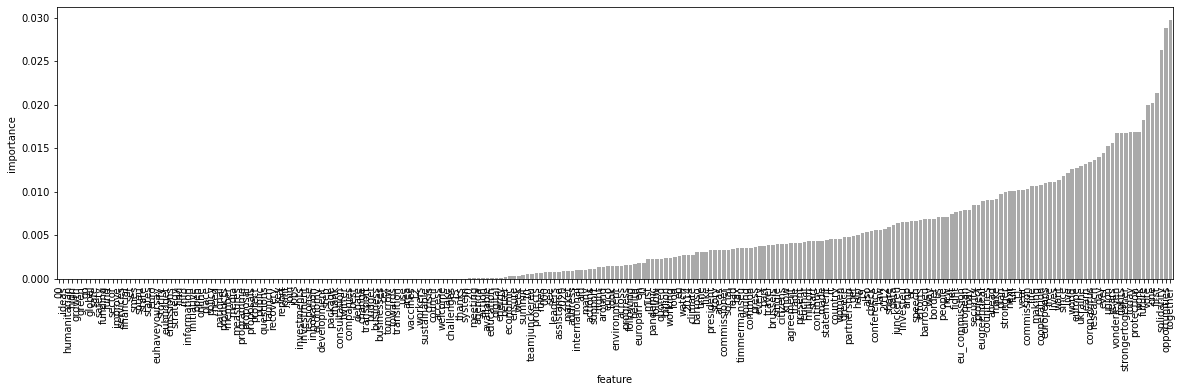

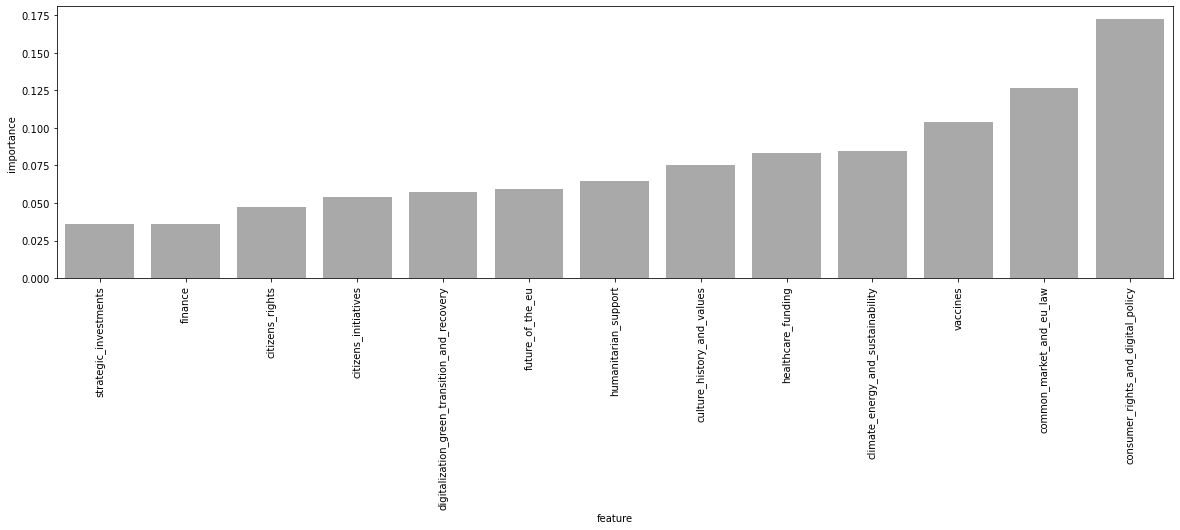

In [207]:
import pickle as pkl
import xgboost
import shap

with xgboost.config_context(verbosity=0):
    for metric in ['sum']:
        print(f'***** {metric} *****')
        fnames = glob.glob(f'logs/metrics/with_cv/{metric}_count/{metric}_count_*.pkl')
        for m in fnames:
            name = m.split('/')[-1]
            model = pkl.load(open(m, 'rb'))
            if 'topic' in m:
                feature_names = list(set(topic_col) - set(exclude_col))
            elif 'style' in m:
                feature_names = style_col
            elif 'combined' in m:
                feature_names = list(set(topic_col) - set(exclude_col)) + emotion_col + style_col 
            elif 'sentiment' in m:
                feature_names = emotion_col
            else:
                bow_nr = m.split('_')[-1].split('.')[0]
                tokenizer = pkl.load(open(f'logs/metrics/with_cv/{metric}_count/tokenizer_bow-{bow_nr}.pkl',
                                          'rb'))
                feature_names = tokenizer.get_feature_names()
                
            df = pd.DataFrame(zip(model.feature_importances_,
                                  feature_names), 
                              columns=['importance', 'feature'])
            df = df.sort_values(by='importance')
            plt.subplots(figsize=(20,5))
            sns.barplot(data=df, x='feature', y='importance', color='darkgrey')
            plt.xticks(rotation=90)
            plt.show()
            
           # shaps = pkl.load(open(f'logs/metrics/with_cv/{metric}_count/shap_{name}','rb'))
           # if not 'topic' in m:
           #     df = df.tail(n=50)
           #     fig, ax = plt.subplots(figsize=(20,4))    
           # shap.summary_plot(shaps, max_display=100, feature_names=feature_names)

    

In [164]:
for m in ['sum']:
    d = pd.read_csv(f'logs/metrics/with_cv/{m}_count/grid.csv').sort_values(by='mean_test_score',
                                                                    ascending=False)